In [1]:
import qctoolkit as qtk
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import re
from datetime import datetime

%matplotlib inline

clear_output()

In [2]:
from horton import GOBasisFamily
#basis = GOBasisFamily('basis', filename='basis/sto2g/H_Ne_uncontracted.nwchem')
#basis = '3-21g'
#basis = 'sto-3g'
#basis = GOBasisFamily('H_He_basis', filename='basis/sto6g/H_Ne.nwchem')
basis = GOBasisFamily('H_He_basis', filename='basis/sto6g/H_Be-s.nwchem')

resolution = 0.002
batch_size = 30000

In [3]:
molstr_list = [
    'HH',
    'HHe+',
    'HLi',
    'HBe+',
#     'HeHe',
#     'HeLi+',
#     'HeBe',
#     'LiLi',
#     'LiBe+',
#     'BeBe',
]

In [4]:
inp_grp = []
#inp_dump = []
for molstr in molstr_list:
    if '+' in molstr:
        charge = 1
    elif '-' in molstr:
        charge = -1
    else:
        charge = 0
    alist = re.findall('[A-Z][a-z]*', molstr)
    Zs = [qtk.n2Z(a) for a in alist]
    inp_list = []
    inp_grp.append(inp_list)
    #inp_dump.append(inp_list)
    res = resolution
    for R in np.arange(0.3, 4.0 + res, res):
        mol = qtk.Molecule()
        ZR = [[Zs[0], 0,0,0], [Zs[1], R, 0, 0]]
        mol.build(ZR)
        mol.charge = charge
        mol.name = mol.name + '_%s' % str(R)
        inp = qtk.QMInp(mol, program='horton', basis_set=basis, scf_step=30)
        try:
            inp.run()
            D, U = np.linalg.eigh(inp.olp)
            inp.X = U / np.sqrt(D)
            
            # to save inps into pickle file
            #inp.delete_ht_types()
            #inp.delete_matrices()
            
            inp_list.append(inp)
        except:
            pass
    print "%s finished" % mol.name
print [len(inp) for inp in inp_grp]

H2_4.0 finished
H1He1_4.0 finished
H1Li1_4.0 finished
H1Be1_4.0 finished
[1851, 1851, 1851, 1407]


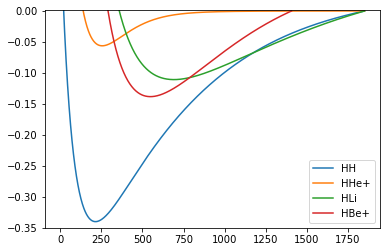

In [5]:
for i in range(len(inp_grp)):
    inp = inp_grp[i]
    E = np.array([o.Et for o in inp])
    E = E-E[-1]
    #print E
    plt.plot(E, label=molstr_list[i])
plt.ylim(-0.35, 0.001)
plt.legend()

In [6]:
# Numpy version implementation

def get_input_tensor(mol):
    """Extract matrices and pack as tensor"""
    S, K, Na, C0, X, Er = mol.olp, mol.kin, mol.na, mol.initial_mov, mol.X, mol.er
    Er_j = np.diagonal(np.diagonal(er))

    Er_x = np.diagonal(np.diagonal(er, axis1=0, axis2=2), axis1=1, axis2=0)
    I = np.stack([S, K, Na, Er_j, Er_x, C0, X])
    nn = mol.ht_external['nn']
    occ = mol.ht_exp_alpha.occupations
    return I, Er, occ, nn
    
def get_output(I, Er, occ, nn, C):
    """take input tensor and approximated MO coefficients, C, to compute total energy"""
    K = I[1]
    Na = I[2]
    dm = (C * occ).dot(C.T)
    
    Ek = np.trace(dm.dot(K)) * 2
    Ev = np.trace(dm.dot(Na)) * 2
    Ej = np.trace(dm.dot(np.tensordot(dm, Er, axes=([0,1], [0,2])))) * 2
    Ex = -np.trace(dm.dot(np.tensordot(dm, Er, axes=([0,1], [0,1]))))
    E_tot = np.sum([Ek, Ev, Ej, Ex, nn])
    return E_tot

inp = inp_grp[0][5]
I_np, Er_np, occ, nn = get_input_tensor(inp)
C = inp.ht_exp_alpha.coeffs.__array__()
print get_output(I_np, Er_np, occ, nn, C)
print inp.Et

-0.673868062839
-0.673868062839


In [7]:
from sklearn.model_selection import train_test_split

def train_test_valid(valid_ind, train_inds=None, random_seed=0):
    if valid_ind >= len(inp_grp):
        valid_ind = len(inp_grp) - 1
    print "%s is used as validation molecule" % molstr_list[valid_ind]
    inp_valid = inp_grp[valid_ind]
    if valid_ind > 0:
        if train_inds is None: train_inds = range(len(inp_grp))
        inps_all = list(qtk.flatten([inp_grp[i] for i in train_inds if i != valid_ind]))
    else:
        inps_all = list(qtk.flatten(inp_grp))
    inp_train, inp_test = train_test_split(inps_all, random_state=random_seed, test_size=0.1)
    return inp_train, inp_test, inp_valid

def validation_inds(inp_valid):
    E = np.array([inp.Et for inp in inp_valid])
    ind_min = np.argmin(E)
    ind_max = len(E) - 1
    ind_mid = ind_min + (ind_max - ind_min) / 2
    ind_rep = ind_min / 2
    return ind_rep, ind_min, ind_mid, ind_max

In [8]:
def tfIO(mol_list, inds=None):
    I_list, Er_list, occ_list, nn_list, C_list, labels = [[] for _ in range(6)]
    
    if inds is None:
        inds = range(len(mol_list))
        
    for i in inds:
        mol = mol_list[i]
        C = mol.ht_exp_alpha.coeffs.__array__()
        C_list.append(C)
        I, Er, occ, nn = get_input_tensor(mol)
        I_list.append(I)
        Er_list.append(Er)
        occ_list.append(occ)
        nn_list.append(nn)
        labels.append(get_output(I, Er, occ, nn, C))
        
    return np.stack(I_list).astype(np.float64), np.stack(Er_list).astype(np.float64), \
           np.stack(occ_list).astype(np.float64), np.stack(nn_list).astype(np.float64), \
           np.stack(C_list).astype(np.float64), np.stack(labels).astype(np.float64)

def tfIO_batch(mol_list, batch_size, inds=None):
    
    def batches(mol_list):
        for i in range(0, len(mol_list), batch_size):
            yield mol_list[i:i + batch_size]

    I, Er, occ, nn, C, y = [], [], [], [], [], []
    if inds is None:
        for mol_batch in batches(mol_list):
            I_b, Er_b, occ_b, nn_b, C_b, y_b = tfIO(mol_batch)
            I.append(I_b)
            Er.append(Er_b)
            occ.append(occ_b)
            nn.append(nn_b)
            C.append(C_b)
            y.append(y_b)
    else:
        I_b, Er_b, occ_b, nn_b, C_b, y_b = tfIO(mol_list, inds)
        I.append(I_b)
        Er.append(Er_b)
        occ.append(occ_b)
        nn.append(nn_b)
        C.append(C_b)
        y.append(y_b)
    return I, Er, occ, nn, C, y

In [9]:
inp_train, inp_test, inp_valid = train_test_valid(0, [0])
# print len(inp_train), len(inp_test), len(inp_valid)
I_train, Er_train, occ_train, nn_train, C_train, y_train = tfIO_batch(inp_train, batch_size)
I_test, Er_test, occ_test, nn_test, C_test, y_test = tfIO_batch(inp_test, batch_size)
I_valid, Er_valid, occ_valid, nn_valid, C_valid, y_valid = tfIO_batch(inp_valid, batch_size)

I_valid2, Er_valid2, occ_valid2, nn_valid2, C_valid2, y_valid2 = tfIO(inp_valid, [1,3,5])
# print I_valid2.shape
# print I_test[0].shape
# print I_train[0].shape
# print validation_inds(inp_valid)

HH is used as validation molecule


In [19]:
import tensorflow as tf

tf.reset_default_graph()

def lrelu(x, alpha):
    return tf.nn.relu(x) - alpha * tf.nn.relu(-x)

def flatten(x_tensor):
    
    if type(x_tensor) is np.ndarray:
        shape = x_tensor.shape
    else:
        shape = x_tensor.get_shape().as_list()
    
    flatten_shape = np.prod(shape[1:])
    
    return tf.reshape(x_tensor, [-1, flatten_shape])

def hidden_layer(I, C_prd=None, Whp=None, bhp=None, Whn=None, bhn=None, keep_prob=1.0, sess=None):
    
    if C_prd is None:
        C_prd = I[:,-2]
        shape = C_prd.shape[-2:]
    else:    
        shape = C_prd.get_shape()[-2:]
        
    S, K, V, Er_j, Er_x = (I[:,i] for i in range(5))
    
    shape_product = int(S.shape[1] * S.shape[2])
    f_input_flatten = flatten(tf.stack((S, K, V, Er_j, Er_x,C_prd), axis=1))
    
    return_Whp = False
    if Whp is None:
        return_Whp = True
        Whp = tf.Variable(tf.truncated_normal(
            (f_input_flatten.get_shape().as_list()[-1], shape_product),
            dtype=tf.float64
        ), dtype=tf.float64, name='weights_hp')

        bhp = tf.Variable(tf.zeros(shape_product, dtype=tf.float64), dtype=tf.float64, name='biases_hp')

        Whn = tf.Variable(tf.truncated_normal(
            (f_input_flatten.get_shape().as_list()[-1], shape_product),
            dtype=tf.float64
        ), dtype=tf.float64, name='weights_hn')

        bhn = tf.Variable(tf.zeros(shape_product, dtype=tf.float64), dtype=tf.float64, name='biases_hn')
    
    if sess:
        sess.run(tf.global_variables_initializer())
        
        print 'stack.shape: ', str(sess.run(tf.stack((S, K, V, C_prd), axis=1)).shape)
        print 'f_input_flatten.shape: ', str(sess.run(f_input_flatten).shape)
        print 'Wh.shape: ', str(sess.run(Whn).shape)
    # returning ReLU(WX + b)
    C_new_flatten_p = lrelu(tf.add(tf.matmul( f_input_flatten, Whp), bhp), 0.1)
    C_new_flatten_n = lrelu(tf.add(tf.matmul(-f_input_flatten, Whn), bhn), 0.1)
    
    C_added = tf.layers.dropout(tf.add(C_new_flatten_p, C_new_flatten_n), keep_prob)
    
    C_new = tf.reshape(C_added , [-1, tf.shape(C_prd)[1], tf.shape(C_prd)[2]])
    
    return C_new, Whp, bhp, Whn, bhn
    
def normailization_layer(I, C_prd, sess=None):

    C_sym = tf.matmul(tf.transpose(C_prd, perm=[0,2,1]), C_prd)

    _, C_diag = tf.self_adjoint_eig(C_sym)
    
    return tf.matmul(I[:,-1], C_diag)

def output_layer(I, Er, occ, nn, C_prd, sess=None):
    K, Na = I[:,1], I[:,2]
    
    batch = tf.shape(I)[0]
    C_occ = tf.multiply(tf.expand_dims(occ, 1), C_prd)
    dm = tf.matmul(C_occ, tf.transpose(C_prd, perm=[0,2,1]))
    
    ind = tf.transpose(tf.stack([tf.range(batch), tf.range(batch)]))
    J_kernel = tf.gather_nd(tf.tensordot(dm, Er, axes=([1,2], [1,3])), ind)
    X_kernel = tf.gather_nd(tf.tensordot(dm, Er, axes=([1,2], [1,2])), ind)
    
    Ek = tf.trace(tf.matmul(dm, K)) * 2
    Ev = tf.trace(tf.matmul(dm, Na)) * 2
    Ej = tf.trace(tf.matmul(dm, J_kernel)) * 2
    Ex = -tf.trace(tf.matmul(dm, X_kernel))
    
    E_total = tf.add(Ek, Ev)
    E_total = tf.add(E_total, Ej)
    E_total = tf.add(E_total, Ex)
    E_total = tf.add(E_total, nn)
    
    return E_total
    
# test
_N = 20
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print C_test[0]
    E = output_layer(I_test[0], Er_test[0], occ_test[0], nn_test[0], C_test[0], sess)
    hidden_out = sess.run(hidden_layer(I_test[0], sess=sess))
    C_sess = hidden_out[0]
    print I_test[0].shape
    print C_sess.shape
    C_orth_init = sess.run(normailization_layer(I_test[0], C_sess, sess))
    print 'C_orth_init.shape',
    print C_orth_init.shape
    print abs(sess.run(E) -y_test[0]).sum()
with tf.Session() as sess:
    C_hidden_test = hidden_layer(I_test[0], sess=sess)

[[[  3.09180307e-05  -6.68852249e-01  -1.20869590e+00  -2.22022629e-01]
  [ -1.22619998e-02  -4.12670442e-01   1.31337528e+00   3.21825977e-01]
  [ -8.71836997e-01   2.47230869e-02  -1.41565503e-01   1.08173331e+00]
  [ -1.72151779e-01   1.60947199e-02   8.91996221e-02  -1.39923248e+00]]

 [[ -1.34752765e-01  -6.75599815e-01  -1.20579693e+00  -1.22658815e-01]
  [ -1.09823526e-02  -5.20783054e-01   1.51222466e+00  -4.59265135e-01]
  [ -8.70057481e-01   2.78158018e-01   4.16904167e-02  -1.10193471e+00]
  [ -1.20130390e-01   2.45902515e-01  -3.72567766e-01   1.68859796e+00]]

 [[ -1.47039071e-03   3.75916506e-01   1.71966339e-01   1.33843257e+00]
  [  4.30587154e-03   5.79397337e-01   3.69022673e-01  -1.25695663e+00]
  [ -9.94676817e-01  -9.59666778e-02   2.48809320e-01  -2.50496483e-02]
  [ -2.18641880e-02   3.48142883e-01  -9.90874997e-01   1.55368331e-01]]

 ..., 
 [[ -1.04730125e-03  -3.17969956e-01  -4.23817893e-01   1.29522123e+00]
  [  2.48489944e-03  -3.41175871e-01  -4.49354098e-

In [47]:
def train(root_name='model', learn_rate_min=0.0001, valid_ind=2, 
          train_list=range(len(inp_grp)), print_step=5,
          threshold=1E-5, maxiter=100000, from_scratch=False,
          learn_rate_steps=50, learn_rate_start=0.1, learn_rate_base=0.5,
          batch_size=batch_size, random_seed=0
         ):
    
    def log_msg(msg, output=True):
        log.write(msg)
        log.flush()
        if output:
            print msg
    
    inp_train, inp_test, inp_valid = train_test_valid(valid_ind, train_list, random_seed)
    print "train/test/validation size: %d/%d/%d" % (len(inp_train), len(inp_test), len(inp_valid))
    I_train, Er_train, occ_train, nn_train, C_train, y_train = tfIO_batch(inp_train, batch_size)
    I_test, Er_test, occ_test, nn_test, C_test, y_test = tfIO_batch(inp_test, batch_size)
    I_valid, Er_valid, occ_valid, nn_valid, C_valid, y_valid = tfIO_batch(inp_valid, batch_size)
    i_rep, i_min, i_mid, i_max = validation_inds(inp_valid)
    v_inds = [i_rep, i_min, i_mid, i_max]
    I_valid2, Er_valid2, occ_valid2, nn_valid2, C_valid2, y_valid2 = tfIO(inp_valid, inds=v_inds)
    
    status = "root name: " + root_name + "\n"
    status += "batch size: " + str(I_train[0].shape[0]) + "\n"
    status += "number of batches: " + str(len(I_train)) + "\n"
    status += "training set: " + str([molstr_list[i] for i in train_list]) + "\n"
    status += "validation: " + molstr_list[valid_ind] + "\n"
    status += "learning rate min: " + str(learn_rate_min) + "\n"
    status += "learning rate steps: " + str(learn_rate_steps) + "\n"
    status += "learning rate start: " + str(learn_rate_start) + "\n"
    status += "learning rate base: " + str(learn_rate_base) + "\n"
    status += "print step: " + str(print_step) + "\n"
    status += "threshold: " + str(threshold) + "\n"
    status += "maxiter: " + str(maxiter) + "\n"
    status += "execuate time: " + datetime.now().strftime("%Y/%m/%d %H:%M:%S") + "\n\n"
    
    log = open("%s.log" % root_name, 'w')
    log_msg(status)

    tf.reset_default_graph()

    def get_shape(tensor):
        shape = list(tensor.shape)
        shape.insert(0, None)
        return shape

    # input tensors
    I = tf.placeholder(tf.float64, shape=get_shape(I_test[0][0]), name='I')
    Er = tf.placeholder(tf.float64, shape=get_shape(Er_test[0][0]), name='Er')
    occ = tf.placeholder(tf.float64, shape=get_shape(occ_test[0][0]), name='occ')
    nn = tf.placeholder(tf.float64, shape=get_shape(nn_test[0][0]), name='nn')
    keep_prob = tf.placeholder(tf.float64, name='keep_prob')

    # training tensors
    y = tf.placeholder(tf.float64, shape=get_shape(y_test[0][0]), name='y')

#     # network architecture
#     C_prd = hidden_layer(I)[0]
#     for _ in range(1):
#         C_prd = hidden_layer(I, C_prd)[0]
#     C_prd = normailization_layer(I, C_prd)
#     #C_prd = normailization_layer(I, C_prd)
#     y_prd = output_layer(I, Er, occ, nn, C_prd)
    
    # network architecture
    C_prd, Wp, bp, Wn, bn = hidden_layer(I)
    #C_prd = hidden_layer(I, C_prd, Wp, bp, Wn, bn, keep_prob=keep_prob)[0]
    for _ in range(4):
        C_prd, Wp, bp, Wn, bn = hidden_layer(I, C_prd)
#     C_prd, Wp, bp, Wn, bn = hidden_layer(I, C_prd)
    #C_prd = hidden_layer(I, C_prd, Wp, bp, Wn, bn, keep_prob=keep_prob)[0]
    for _ in range(2):
        C_prd = hidden_layer(I, C_prd, Wp, bp, Wn, bn)[0]
    C_prd, Wp, bp, Wn, bn = hidden_layer(I, C_prd)
    #C_prd = hidden_layer(I, C_prd, Wp, bp, Wn, bn, keep_prob=keep_prob)[0]
    for _ in range(2):
        C_prd = hidden_layer(I, C_prd, Wp, bp, Wn, bn)[0]
    C_prd = hidden_layer(I, C_prd)[0]
    C_prd = normailization_layer(I, C_prd)
    y_prd = output_layer(I, Er, occ, nn, C_prd)

    # network output
    C_out = C_prd
    #err = tf.pow(y - y_prd, 2)
    #err = tf.metrics.mean_squared_error(y, y_prd)
    err = tf.reduce_mean(tf.pow(y - y_prd, 2))

    # add C_prd_iteration history for post processing on the learning of the following properties
    # 1. density difference
    # 2. force
    # 3. dipole moment
    # 4. HOMO-LUMO gap

    n_epoch = tf.Variable(0, trainable=False)
    learn_rate = tf.maximum(tf.train.exponential_decay(
                                learn_rate_start, n_epoch, learn_rate_steps, learn_rate_base),
                            learn_rate_min
                           )
    
    optimizer = tf.train.AdamOptimizer(learn_rate).minimize(err) # default learning rate 0.001
    #optimizer = tf.train.GradientDescentOptimizer(learn_rate).minimize(err) 
    saver = tf.train.Saver()
    save_path = "%s.ckpt" % root_name

    #with tf.Session() as sess:
    sess = tf.Session()
    try:
        train_err_hist = []
        test_err_hist = []
        valid_err_hist = []
        C_valid_hist = []
        C_test_hist = []
        learn_rate_hist = []

        if not from_scratch:
            try:
                saver.restore(sess, save_path)
                train_err_hist, test_err_hist, valid_err_hist, C_valid_hist, C_test_hist, learn_rate_hist = \
                qtk.load('%s_hist.pkl' % root_name)
                msg = 'model and history loaded, continue optimizing'
            except:
                sess.run(tf.global_variables_initializer())
                msg = 'no model found, or reload failed, start from scratch'
        else:
            msg = 'start from scratch...'
            sess.run(tf.global_variables_initializer())
        log_msg(msg + "\n")
        test_err = 1
        epoch = len(test_err_hist)
        while test_err > threshold and epoch < maxiter:
        #for opt_itr in range(200):

            train_err_list = []
            for I_b, Er_b, occ_b, nn_b, C_b, y_b in zip(I_train, Er_train, occ_train, nn_train, C_train, y_train):
                train_dict = {I:I_b, Er:Er_b, occ:occ_b, nn:nn_b, y:y_b, keep_prob:0.8, n_epoch:epoch}
                sess.run(optimizer, feed_dict=train_dict)
                #train_err_list.append(np.array(sess.run(err, feed_dict=train_dict)))
                train_err_list.append(sess.run(err, feed_dict=train_dict))
            #train_err = np.concatenate(train_err_list).mean()
            train_err = np.array(train_err_list).mean()
            train_err_hist.append(train_err)
            current_learn_rate = sess.run(learn_rate, feed_dict=train_dict)
            learn_rate_hist.append(current_learn_rate)

            test_err_list = []
            for I_t, Er_t, occ_t, nn_t, C_t, y_t in zip(I_test, Er_test, occ_test, nn_test, C_test, y_test):
                test_dict = {I:I_t, Er:Er_t, occ:occ_t, nn:nn_t, y:y_t, keep_prob:1.0}
                #test_err_list.append(np.array(sess.run(err, feed_dict=test_dict)))
                test_err_list.append(sess.run(err, feed_dict=test_dict))
            #test_err = np.concatenate(test_err_list).mean()
            test_err = np.array(test_err_list).mean()
            test_err_hist.append(test_err)
            
            test2_dict = {
                I:I_test[0][:3], 
                Er:Er_test[0][:3], 
                occ:occ_test[0][:3], 
                nn:nn_test[0][:3], 
                y:y_test[0][:3],
                keep_prob:1.0
            }
            C_test_hist.append(np.array(sess.run(C_out, feed_dict=test2_dict)))

            valid_err_list = []
            for I_v, Er_v, occ_v, nn_v, C_v, y_v in zip(I_valid, Er_valid, occ_valid, nn_valid, C_valid, y_valid):
                valid_dict = {I:I_v, Er:Er_v, occ:occ_v, nn:nn_v, y:y_v, keep_prob:1.0}
                #valid_err_list.append(np.array(sess.run(err, feed_dict=valid_dict)))
                valid_err_list.append(sess.run(err, feed_dict=valid_dict))
            #valid_err = np.concatenate(valid_err_list).mean()
            valid_err = np.array(valid_err_list).mean()
            valid_err_hist.append(valid_err)
            
            valid2_dict = {I:I_valid2, Er:Er_valid2, occ:occ_valid2, nn:nn_valid2, y:y_valid2}
            C_valid_hist.append(np.array(sess.run(C_out, feed_dict=valid2_dict)))

            epoch = len(test_err_hist)
            msg = "epoch: %5d train/test/validatoin error: %f/%f/%f at rate %f" % \
            (epoch, train_err, test_err, valid_err, current_learn_rate)
            
            log_msg(msg + "\n", False)
            
            #epoch += 1
            
            if epoch % print_step == 0:
                print msg
                qtk.save([train_err_hist, test_err_hist, valid_err_hist, C_valid_hist, C_test_hist], 
                         "%s_hist.pkl" % root_name)
                
        save_path_out = saver.save(sess, save_path)
        msg = "Model saved in file: %s" % save_path_out
        log_msg(msg + "\n")
        qtk.save([train_err_hist, test_err_hist, valid_err_hist, C_valid_hist, C_test_hist, learn_rate_hist], 
                 "%s_hist.pkl" % root_name)
        print "optimization history saved"
        log.close()
        sess.close()
        print "session and log file closed"

    except KeyboardInterrupt:
        new_msg = "keyboard interrupt, current stage: %s" % msg
        log_msg(new_msg + "\n")
        save_path_out = saver.save(sess, save_path)
        msg = "Model saved in file: %s" % save_path_out
        log_msg(msg + "\n")
        qtk.save([train_err_hist, test_err_hist, valid_err_hist, C_valid_hist, C_test_hist, learn_rate_hist], 
                 "%s_hist.pkl" % root_name)
        print "optimization history saved"
        log.close()
        sess.close()
        print "session and log file closed"

In [ ]:
lr = 1.0

#train('test', 0.001, 2, from_scratch=True, print_step=50)
# train('deep_test', valid_ind=0, from_scratch=True, learn_rate_start=lr, learn_rate_min=lr, learn_rate_base=1.0, 
#       batch_size=8000, print_step=1) # constant learning rate
train('deep_test', valid_ind=2, from_scratch=False, print_step=1, 
      learn_rate_start=lr, learn_rate_min=0.00005, learn_rate_steps=50, learn_rate_base=0.8, batch_size=8000)

HLi is used as validation molecule
train/test/validation size: 4598/511/1851
root name: deep_test
batch size: 4598
number of batches: 1
training set: ['HH', 'HHe+', 'HLi', 'HBe+']
validation: HLi
learning rate min: 5e-05
learning rate steps: 50
learning rate start: 1.0
learning rate base: 0.8
print step: 1
threshold: 1e-05
maxiter: 100000
execuate time: 2017/09/28 15:50:48


start from scratch...

epoch:     1 train/test/validatoin error: 26.870086/30.120263/32.097009 at rate 1.000000
epoch:     2 train/test/validatoin error: 2.008417/1.939163/0.688719 at rate 0.995547
epoch:     3 train/test/validatoin error: 1.784662/1.653239/1.242038 at rate 0.991114
epoch:     4 train/test/validatoin error: 1.133613/1.233403/0.940112 at rate 0.986701
epoch:     5 train/test/validatoin error: 1.265072/1.384170/0.989672 at rate 0.982307
epoch:     6 train/test/validatoin error: 1.409429/1.532095/0.994119 at rate 0.977933
epoch:     7 train/test/validatoin error: 1.435323/1.554617/0.991420 at rate 0.9

In [55]:
# def train(root_name='model', learn_rate=0.001, valid_ind=2, 
#           train_list=range(len(inp_grp)), print_step=5, from_scratch=False,
#           threshold=1E-5, maxiter=100000
#          ):

total_list = range(10)
tags = [str(i) for i in range(1, 10)]
inds = [total_list[:i] for i in range(1, 10)]

del tags[2]
del inds[2]

for i in range(len(tags)):
    tag = tags[i]
    ind = inds[i]
    train('increment_full_2-%s' % tag, 0.02, 2, ind, 10)